In [1]:
import numpy as np
from scipy.optimize import least_squares

# 震动波的传播速度 (m/s)
speed_of_sound = 340

# 监测设备的三维坐标 (经度, 纬度, 高度) 和音爆到达时间 (单位: 秒)
devices = np.array([
    [110.241, 27.204, 824, 100.767],
    [110.780, 27.456, 727, 112.220],
    [110.712, 27.785, 742, 188.020],
    [110.251, 27.825, 850, 258.985],
    [110.524, 27.617, 786, 118.443],
    [110.467, 27.921, 678, 266.871],
    [110.047, 27.121, 575, 163.024]
])

# 经纬度转换为米，纬度间每度 111263 米，经度间每度 97304 米
lat_conversion = 111263
lon_conversion = 97304

# 转换经纬度为米并计算距离
device_positions = np.array([
    [lon_conversion * (device[0] - devices[0, 0]), 
     lat_conversion * (device[1] - devices[0, 1]), 
     device[2]]
    for device in devices
])

# 音爆到达时间
arrival_times = devices[:, 3]

# 定义残骸的真实位置（假设值，或可根据某次实际结果得到）
true_position = np.array([1000, 1000, 500])
true_time = 200.0

# 定义损失函数，用于最小化距离的差异
def residuals(params, selected_devices, selected_times):
    x, y, z, t0 = params
    theoretical_times = [
        t0 + np.linalg.norm([x - pos[0], y - pos[1], z - pos[2]]) / speed_of_sound
        for pos in selected_devices
    ]
    return np.array(theoretical_times) - selected_times

# 定义一个函数来测试不同数量的设备并量化其稳定性
def test_stability(min_devices, max_experiments=100):
    stability_results = []
    
    for i in range(min_devices, len(devices) + 1):
        results = []
        
        for _ in range(max_experiments):
            # 随机选择 i 台设备
            indices = np.random.choice(len(devices), i, replace=False)
            selected_devices = device_positions[indices]
            selected_times = arrival_times[indices]

            # 初始猜测
            initial_guess = np.array([0, 0, 150, 4.00])

            # 设置约束条件：t0 >= 0
            bounds = ([-np.inf, -np.inf, -np.inf, 0], np.inf)

            # 使用最小二乘法，带有约束条件
            result = least_squares(residuals, initial_guess, bounds=bounds, args=(selected_devices, selected_times))

            # 记录预测结果
            predicted_position = result.x[:3]
            predicted_time = result.x[3]
            results.append(np.concatenate([predicted_position, [predicted_time]]))
        
        # 计算每次实验结果的均值和标准差，量化稳定性
        results = np.array(results)
        mean_result = np.mean(results, axis=0)
        std_deviation = np.std(results, axis=0)
        
        # 记录当前设备数量下的稳定性指标
        stability_results.append((i, mean_result, std_deviation))
        print(f"设备数量: {i}, 平均结果: {mean_result}, 标准差: {std_deviation}")
        
    return stability_results

# 从3台设备开始测试，最多进行100次实验以评估稳定性
stability_data = test_stability(3, max_experiments=100)


设备数量: 3, 平均结果: [ 3.54731920e+04  4.75982699e+03 -1.42935857e+03  1.44683435e+01], 标准差: [12189.62703698 12242.57506382  6079.46157446    27.24077891]
设备数量: 4, 平均结果: [ 3.52522144e+04  1.46017693e+03 -5.46266015e+01  1.12162510e+01], 标准差: [6125.13013592 9523.58337828 5231.16702457   20.08899513]
设备数量: 5, 平均结果: [3.56024514e+04 8.32664883e+01 8.15433590e+02 8.04772675e+00], 标准差: [2982.37641531 8217.56799647  185.68894547   20.10367718]
设备数量: 6, 平均结果: [ 3.57709715e+04 -3.14083812e+03  8.34504776e+02  1.44867868e+00], 标准差: [1808.06035512 2528.93488909   83.70098397    3.36545547]
设备数量: 7, 平均结果: [ 3.61818260e+04 -3.57381911e+03  8.49162054e+02  8.86197101e-21], 标准差: [8.54060328e-05 5.55325252e-04 3.86418588e-02 1.84136606e-21]


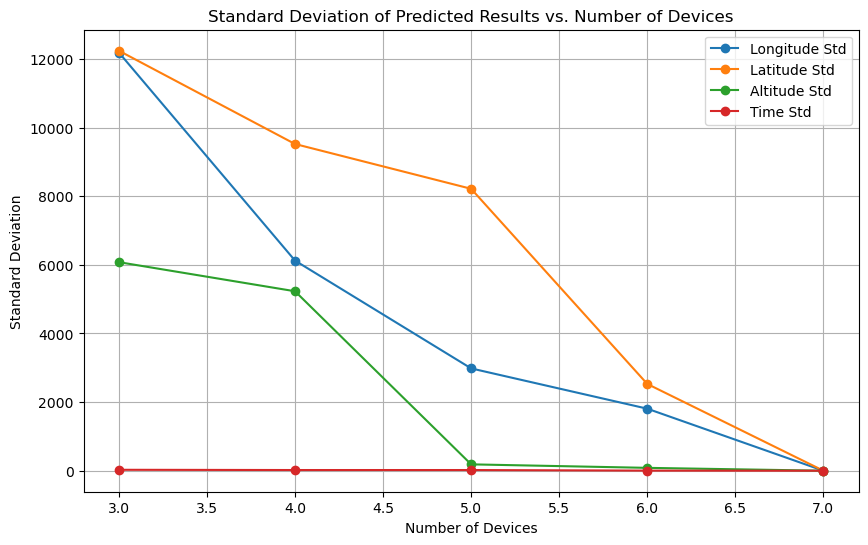

In [2]:
import matplotlib.pyplot as plt

# 提取稳定性数据的设备数量、均值和标准差
device_counts = [data[0] for data in stability_data]
mean_results = [data[1] for data in stability_data]
std_deviations = [data[2] for data in stability_data]

# 分别获取经度、纬度、高度和时间的标准差
std_longitude = [std[0] for std in std_deviations]
std_latitude = [std[1] for std in std_deviations]
std_altitude = [std[2] for std in std_deviations]
std_time = [std[3] for std in std_deviations]

# 绘制标准差随设备数量变化的图表
plt.figure(figsize=(10, 6))

# 经度标准差
plt.plot(device_counts, std_longitude, label='Longitude Std', marker='o')
# 纬度标准差
plt.plot(device_counts, std_latitude, label='Latitude Std', marker='o')
# 高度标准差
plt.plot(device_counts, std_altitude, label='Altitude Std', marker='o')
# 时间标准差
plt.plot(device_counts, std_time, label='Time Std', marker='o')

# 添加标题和标签
plt.title('Standard Deviation of Predicted Results vs. Number of Devices')
plt.xlabel('Number of Devices')
plt.ylabel('Standard Deviation')
plt.legend()

# 显示图表
plt.grid(True)
plt.show()


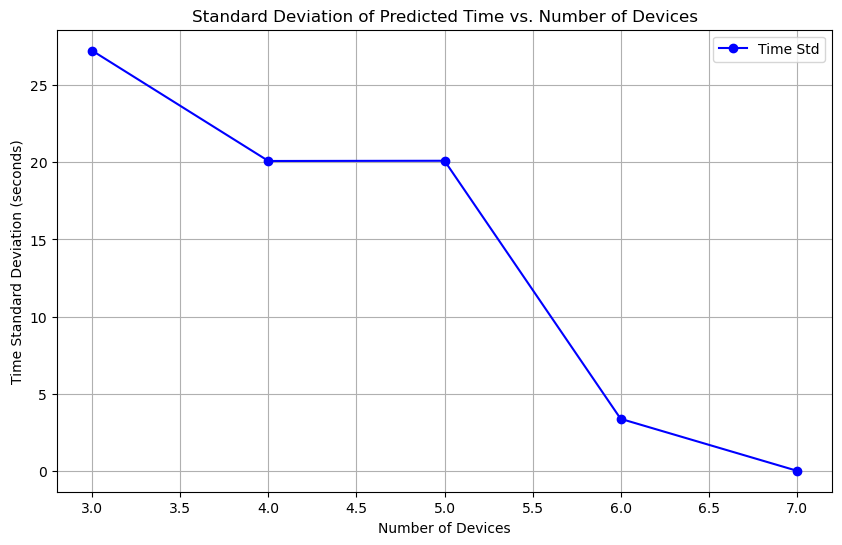

In [3]:
import matplotlib.pyplot as plt

# 绘制时间标准差随设备数量变化的图表
plt.figure(figsize=(10, 6))

# 绘制时间标准差曲线
plt.plot(device_counts, std_time, label='Time Std', marker='o', color='blue')

# 添加标题和标签
plt.title('Standard Deviation of Predicted Time vs. Number of Devices')
plt.xlabel('Number of Devices')
plt.ylabel('Time Standard Deviation (seconds)')
plt.legend()

# 显示图表
plt.grid(True)
plt.show()
